In [153]:
import keras

from keras.layers import Input, Dense, Activation, BatchNormalization
from keras.models import Model
import keras.regularizers as regularizers
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.metrics

def create_default_model(nfeatures, neurons=[64, 32, 4]):
    input_layer = Input(shape=(nfeatures, ))
    current_layer = input_layer
    current_layer = BatchNormalization()(current_layer)
    
    for ncount in neurons:
        current_layer = Dense(ncount, activation='relu', kernel_regularizer=regularizers.l2(0.01))(current_layer)
        current_layer = BatchNormalization()(current_layer)
    
    output_layer = Dense(1, activation='sigmoid')(current_layer)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [199]:
import pandas
df = pandas.read_csv("SBA_504_clean.csv")
df = df.sample(frac=1).reset_index(drop=True)

df['Surv1Year'] = (df['LoanAge'] > 12) | (df['LoanStatus'] == 'PIF')
df['Surv5Year'] = (df['LoanAge'] > 60) | (df['LoanStatus'] == 'PIF')

categorical_variables = ['BorrState', 'DeliveryMethod', 'subpgmdesc', 'NaicsCode', 'BusinessType', 'LoanStatus', 'BankBorrowerStateInd']
boolean_variables = ['TermIntMultOfYear', 'ProjectBorrowerStateInd']
cast_dict = {x: 'category' for x in categorical_variables}
cast_dict.update({x: bool for x in boolean_variables})

df = df.astype(cast_dict)
df = df.drop(df.columns[0], axis=1)

cat_columns = df.select_dtypes(['category']).columns

df2 = pandas.DataFrame(index=df.index)
for cat_var in categorical_variables:
    df2 = pandas.concat([df2, pandas.get_dummies(df[cat_var], prefix=cat_var)], axis=1)

df_fixed = pandas.concat([df.drop(cat_columns, axis=1), df2], axis=1)
df_fixed

C:\Users\peter\Anaconda3\envs\machine-learning\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ThirdPartyDollars,GrossApproval,InitialInterestRate,TermInMonths,GrossChargeOffAmount,LoanAmount,ApprovalYear,LoanAge,TermIntMultOfYear,ProjectBorrowerStateInd,...,NaicsCode_99,BusinessType_(Missing),BusinessType_CORPORATION,BusinessType_INDIVIDUAL,BusinessType_PARTNERSHIP,LoanStatus_CHGOFF,LoanStatus_PIF,BankBorrowerStateInd_(Missing),BankBorrowerStateInd_FALSE,BankBorrowerStateInd_TRUE
0,5.500000e+05,317000,0.0325,240,0.0,867000.0,2007,240.0,True,True,...,0,0,1,0,0,0,1,0,1,0
1,4.884100e+06,1300000,0.0325,240,0.0,6184100.0,2002,240.0,True,True,...,0,0,1,0,0,0,1,0,1,0
2,8.441971e+05,275000,0.0325,240,0.0,275000.0,1992,240.0,True,True,...,0,0,1,0,0,0,1,1,0,0
3,8.441971e+05,519000,0.0325,240,0.0,519000.0,1995,240.0,True,True,...,0,0,1,0,0,0,1,1,0,0
4,1.255000e+06,1079000,0.0325,240,0.0,2334000.0,2004,240.0,True,True,...,0,0,1,0,0,0,1,0,1,0
5,8.441971e+05,248000,0.0325,240,0.0,248000.0,1995,240.0,True,True,...,0,0,0,1,0,0,1,1,0,0
6,2.700000e+05,191000,0.0325,120,0.0,461000.0,2008,120.0,True,True,...,0,0,1,0,0,0,1,0,1,0
7,8.441971e+05,383000,0.0325,240,0.0,383000.0,2000,240.0,True,True,...,0,0,1,0,0,0,1,1,0,0
8,8.441971e+05,703000,0.0325,240,0.0,703000.0,1995,48.0,True,True,...,0,0,1,0,0,1,0,1,0,0
9,8.441971e+05,330000,0.0325,240,0.0,330000.0,1996,240.0,True,True,...,0,0,1,0,0,0,1,1,0,0


In [200]:
prediction_columns = ['LoanAge', 'GrossChargeOffAmount', 'LoanStatus_PIF', 'LoanStatus_CHGOFF', 'Surv1Year', 'Surv5Year']
other_dropped_columns = ['ApprovalYear']
df_matrix = df_fixed.drop(prediction_columns+other_dropped_columns, axis=1)

df_surv_1_year = df_fixed['Surv1Year']
df_surv_5_year = df_fixed['Surv5Year']
df_loss = df_fixed['GrossChargeOffAmount']
df_chgoff = df_fixed['LoanStatus_CHGOFF']
df_matrix.columns

Index(['ThirdPartyDollars', 'GrossApproval', 'InitialInterestRate',
       'TermInMonths', 'LoanAmount', 'TermIntMultOfYear',
       'ProjectBorrowerStateInd', 'CPI', 'SP500', 'PI',
       ...
       'NaicsCode_81', 'NaicsCode_92', 'NaicsCode_99',
       'BusinessType_(Missing)', 'BusinessType_CORPORATION',
       'BusinessType_INDIVIDUAL', 'BusinessType_PARTNERSHIP',
       'BankBorrowerStateInd_(Missing)', 'BankBorrowerStateInd_FALSE',
       'BankBorrowerStateInd_TRUE'],
      dtype='object', length=119)

In [201]:
default_model = create_default_model(df_matrix.shape[1], neurons=[64, 8])

In [171]:
def create_loss_model(nfeatures, neurons=[64, 32, 4]):
    input_layer = Input(shape=(nfeatures, ))
    current_layer = input_layer
    
    for ncount in neurons:
        current_layer = Dense(ncount, activation='relu')(current_layer)
    
    output_layer = Dense(1, activation='linear')(current_layer)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

In [172]:
loss_model = create_loss_model(df_matrix.shape[1])
loss_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 120)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 64)                7744      
_________________________________________________________________
dense_100 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_101 (Dense)            (None, 4)                 132       
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 5         
Total params: 9,961
Trainable params: 9,961
Non-trainable params: 0
_________________________________________________________________


In [202]:
def load_data_matrix():
    
    data_matrix = df_matrix.to_numpy()
    defaults = df_chgoff.to_numpy()
    losses = df_loss.to_numpy()
    defaults_1 = 1 - df_surv_1_year.to_numpy()
    defaults_5 = 1 - df_surv_5_year.to_numpy()
    return data_matrix, defaults, losses, defaults_1, defaults_5

data_matrix, defaults, losses, defaults_1, defaults_5 = load_data_matrix()


split_indices = [2000]

defaults_years = [defaults_1, defaults_5]

test_data, training_data = np.split(data_matrix, split_indices) # dev data is handled by keras


defaults_test, defaults_train = np.split(defaults, split_indices)

print("Amount of test and training data: {}, {}".format(test_data.shape[0], training_data.shape[0]))

Amount of test and training data: 2000, 52806


In [174]:
training_data.shape

(52806, 120)

In [203]:
default_model.fit(x=training_data, y=defaults_train, epochs=2, validation_split=0.05)

Train on 50165 samples, validate on 2641 samples
Epoch 1/2
50165/50165 [==============================] - 41s 825us/step - loss: 0.5564 - acc: 0.8368 - val_loss: 0.3571 - val_acc: 0.8595
Epoch 2/2
50165/50165 [==============================] - 36s 718us/step - loss: 0.3630 - acc: 0.8581 - val_loss: 0.3484 - val_acc: 0.8561


In [204]:
evaluation = default_model.evaluate(x=test_data, y=defaults_test)
print("Evaluation: {}".format(evaluation))

plt.clf()

prediction_vector = default_model.predict(test_data)
cm = sklearn.metrics.confusion_matrix(defaults_test, (prediction_vector > 0.5).astype(float))
print("Confusion matrix for model: {}".format(cm))
roc_fpr, roc_tpr, thresholds = sklearn.metrics.roc_curve(defaults_test, prediction_vector)
plt.plot(roc_fpr, roc_tpr)
lin_space = np.linspace(0, 1, len(roc_fpr))
plt.plot(lin_space, lin_space, 'r--')
plt.savefig('roc_model.png')
plt.clf()

print('AUC: {}'.format(sklearn.metrics.auc(roc_fpr, roc_tpr)))

2000/2000 [==============================] - 0s 174us/step
Evaluation: [0.32983705949783326, 0.87]
Confusion matrix for model: [[1607   83]
 [ 177  133]]
AUC: 0.8463409047528154


<Figure size 432x288 with 0 Axes>

In [19]:
print(data_matrix)

[[307000.0 203000 0.0325 ... 0 1 0]
 [844197.0517741841 535000 0.0325 ... 1 0 0]
 [844197.0517741841 315000 0.0325 ... 1 0 0]
 ...
 [825000.0 511000 0.0325 ... 0 0 1]
 [844197.0517741841 823000 0.0325 ... 1 0 0]
 [576290.0 415000 0.0325 ... 0 0 1]]


In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [135]:
def sample_total_loss(nloans=500, approval_column=0, years_idx=0, rectify=False):
    idx = np.random.choice(data_matrix.shape[0], nloans, replace=False)
    subset = data_matrix[idx, :]
    defaults_vec = defaults_years[years_idx][idx]
    
    if rectify:
        defaults_vec = defaults_vec > 0.5
        
    losses_vec = losses[idx]
    
    total_loss = np.sum(losses_vec * defaults_vec)
    
    total_loan_amount = np.sum(subset[:, approval_column])
    
    return total_loss / total_loan_amount

In [206]:
sampled_losses = np.array([sorted(sample_total_loss(years_idx=i, approval_column=2, rectify=True) for _ in range(100)) for i in range(2)])

In [207]:
sampled_losses

array([[      0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
        

In [208]:
def calculate_value_at_risk(confidence=0.99):
    idx1 = (1 - confidence)/2
    idx2 = (1 - confidence)/2 + confidence
    
    idx1 = idx1 * losses.shape[1]
    idx2 = idx2 * (losses.shape[1] - 1)
    
    lower_band_loss = losses[:, idx1]
    value_at_risk = losses[:, idx2]
    average_value_at_risk = np.mean(sampled_losses[:, idx2:], axis=1)
    
    return value_at_risk, average_value_at_risk, lower_band_loss

    

In [209]:
def calculate_loss(tranche, loss_amount):
    '''
    if loss_amount <= tranche[0]:
        return 0
    
    if loss_amount >= tranche[1]:
        return 1
    
    '''
    
    return np.minimum(1, np.maximum(loss_amount - tranche[0], 0) / (tranche[1] - tranche[0]))

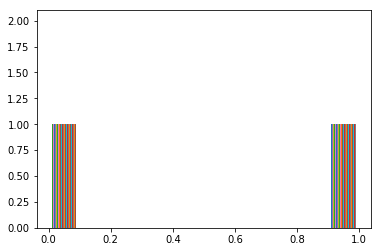

In [210]:
tranche_losses_junior = calculate_loss([0.05, 0.15], sampled_losses)
tranche_losses_senior = calculate_loss([0.15, 1], sampled_losses)

plt.hist(tranche_losses_junior)
plt.savefig('tranche_losses_junior_hist.png')
plt.clf()
plt.hist(tranche_losses_senior)
plt.savefig('tranche_losses_senior_hist.png')